# Домашняя работа

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.datasets import load_boston

In [ ]:
X, y = load_boston(return_X_y=True)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaller = MinMaxScaler()
X_train = scaller.fit_transform(X_train)
X_test = scaller.transform(X_train)

In [ ]:
batch_size = 113
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)) 
train_dataset = train_dataset.shuffle(buffer_size=X_train.shape[0]).batch(batch_size) 

## Задание №1. Постройте нейронную сеть (берем несложную полносвязную сеть, меняем число слоев, число нейронов, типы активации, тип оптимизатора) на датасете from sklearn.datasets import load_boston.

In [ ]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError

import matplotlib.pyplot as plt

In [ ]:
X_train.shape

(339, 13)

### 1.1. Зависимость ошибки от числа нейронов

In [ ]:
def simple_nn(
    X_train,
    y_train,
    layers_numbers=2, 
    neuron_numbers=100, 
    activations='relu', 
    optimazers=SGD(learning_rate=1e-2), 
    epochs=10,
    verbose=0):
  
  tf.random.set_seed(42)
  grad_log = []
  losses = []

  loss = MeanSquaredError()
  
  input = Input(shape=X_train.shape[1], name='fashion') 
  x = input
  
  for i, layer in enumerate(range(layers_numbers - 1)):
    x = Dense(neuron_numbers, activation=activations, name=f'dense_{i}')(x)

  output = Dense(1, activation='relu', name='predictions')(x)

  model = Model(inputs=input, outputs=output)

  for epoch in range(epochs):
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
      with tf.GradientTape() as tape: 
        # Запустим прямой проход слоя
        preds = model(X_train) 

        # Вычислим значение потерь для этого батча
        loss_value = loss(y_train, preds)

        # Используем gradient tape для автоматического извлечения градиентов 
        # обучаемых переменных относительно потерь
        grads = tape.gradient(loss_value, model.trainable_weights) 
        g_g = []

        # пишем логи для сохранения значений градиента и веса по одной цепи 
        for g_s in grads:
            # допишем логи значений градиента в зависимости от размера тензора градиента
            # if len(g_s.numpy().shape) == 1:
            #     g_g.append(g_s.numpy()[0])
            if len(g_s.numpy().shape) == 2:
                g_g.append(g_s.numpy()[0, 0])

      # добавляем текущие логи по слоям к общей записи
      grad_log.append(g_g)

      # Выполним один шаг градиентного спуска,
      # обновив значение переменных минимизирующих потери
      optimazers.apply_gradients(zip(grads, model.trainable_weights)) 

      if verbose:
        # Пишем лог каждый шаг
        print(f'Эпоха {epoch + 1}/{epochs}', end='. ')
        print(f'Шаг {step}. Лосс на обучении (для одного батча) на шаге: {loss_value}') 
        print(f'Уже увидели: {(step + 1) * batch_size} примеров')

      losses.append(loss_value.numpy())
    
  return losses

In [ ]:
result_table = pd.DataFrame(columns=['neuron_num', 'layers_num', 'activation', 'optimizer','loss'])

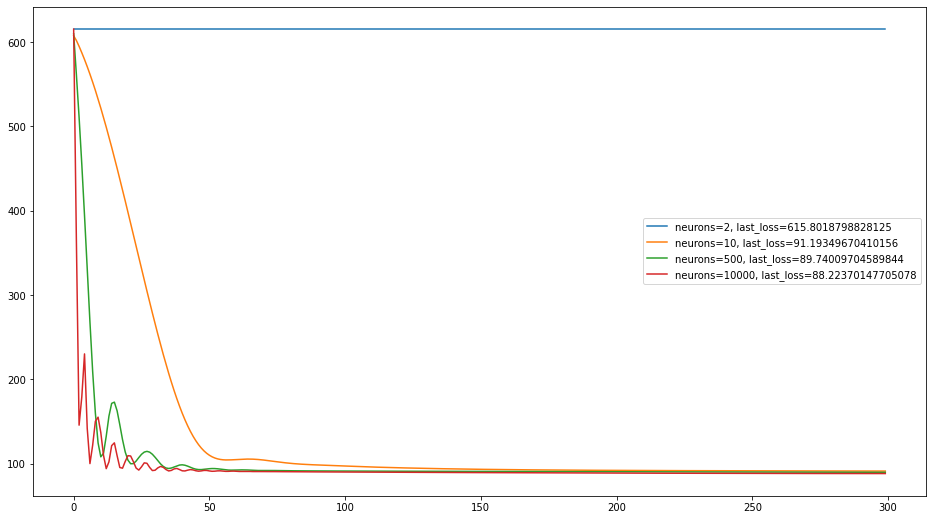

In [ ]:
plt.figure(figsize=(16, 9))


for neuron_num in [2, 10, 500, 10000]:
  loss = simple_nn(X_train, 
            y_train, 
            optimazers=Adam(learning_rate=1e-2),
            neuron_numbers=neuron_num,
            epochs=100)
  plt.plot(loss,
           label='neurons={}, last_loss={}'.format(neuron_num, round(loss[-1], 4))
  )

  result_table = result_table.append(pd.DataFrame(
    columns=['neuron_num', 'layers_num', 'activation', 'optimizer','loss'],
    data=[[neuron_num, 2, 'renu', 'Adam', loss[-1]]]))

plt.legend(loc='best')
plt.show()

In [ ]:
result_table

,neuron_num,layers_num,activation,optimizer,loss
0,2,2,renu,Adam,615.801880
0,10,2,renu,Adam,91.193497
0,500,2,renu,Adam,89.740074
0,10000,2,renu,Adam,88.223701


### 1.2 Зависимость ошибки от числа слоев в нейронной сети

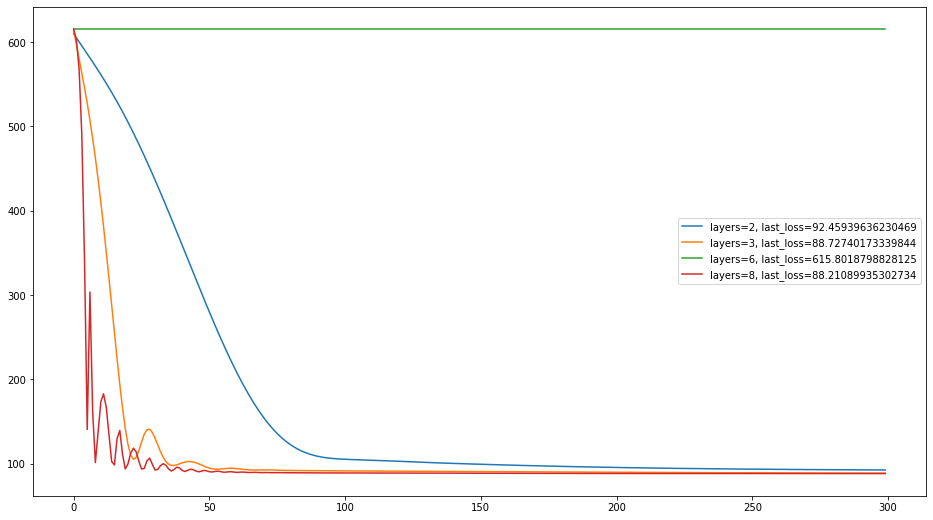

In [ ]:
plt.figure(figsize=(16, 9))


for layers in [2, 3, 6, 8]:
  loss = simple_nn(X_train, 
            y_train, 
            optimazers=Adam(learning_rate=1e-3),
            neuron_numbers=500,
            layers_numbers=layers,
            epochs=100)
  plt.plot(loss,
           label='layers={}, last_loss={}'.format(layers, round(loss[-1], 4))
  )

  result_table = result_table.append(pd.DataFrame(
    columns=['neuron_num', 'layers_num', 'activation', 'optimizer','loss'],
    data=[[500, layers, 'renu', 'Adam', loss[-1]]]))

plt.legend(loc='best')
plt.show()

In [ ]:
result_table

,neuron_num,layers_num,activation,optimizer,loss
0,2,2,renu,Adam,615.801880
0,10,2,renu,Adam,91.193497
0,500,2,renu,Adam,89.740074
0,10000,2,renu,Adam,88.223701
0,500,2,renu,Adam,92.459419
0,500,3,renu,Adam,88.727356
0,500,6,renu,Adam,615.801880
0,500,8,renu,Adam,88.210854


### 1.3 Зависимость ошибки от типов активации слоев

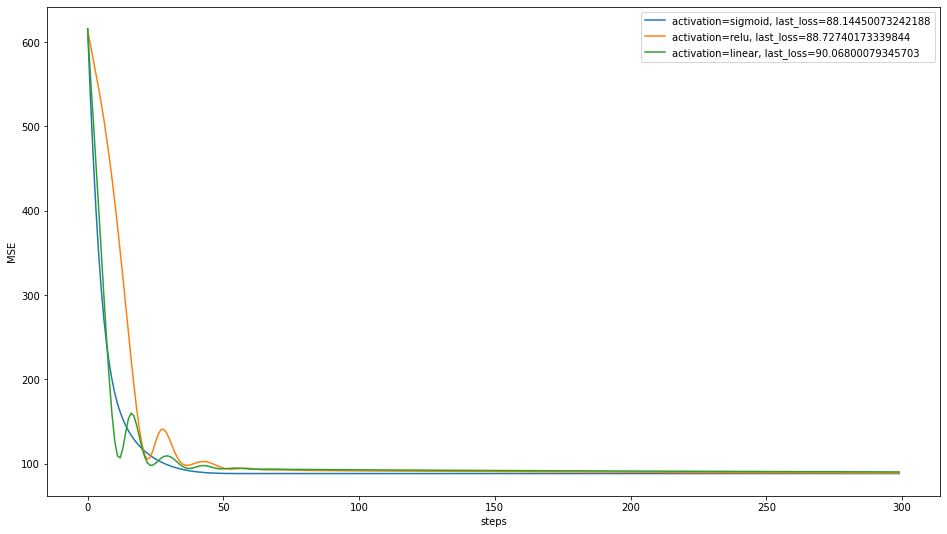

In [ ]:
plt.figure(figsize=(16, 9))


for actiovation in ['sigmoid', 'relu', 'linear']:
  loss = simple_nn(X_train, 
            y_train, 
            optimazers=Adam(learning_rate=1e-3),
            neuron_numbers=500,
            layers_numbers=3,
            epochs=100,
            activations=actiovation)
  plt.plot(loss,
           label='activation={}, last_loss={}'.format(actiovation, round(loss[-1], 4))
  )

  result_table = result_table.append(pd.DataFrame(
    columns=['neuron_num', 'layers_num', 'activation', 'optimizer','loss'],
    data=[[500, 3, actiovation, 'Adam', loss[-1]]]))

plt.legend(loc='best')
plt.xlabel('steps')
plt.ylabel('MSE')
plt.show()

In [ ]:
result_table

,neuron_num,layers_num,activation,optimizer,loss
0,2,2,renu,Adam,615.801880
0,10,2,renu,Adam,91.193497
0,500,2,renu,Adam,89.740074
0,10000,2,renu,Adam,88.223701
0,500,2,renu,Adam,92.459419
0,500,3,renu,Adam,88.727356
0,500,6,renu,Adam,615.801880
0,500,8,renu,Adam,88.210854
0,500,3,sigmoid,Adam,88.144463
0,500,3,relu,Adam,88.727356


### 1.4. Зависимость ошибки от типа оптимизатора

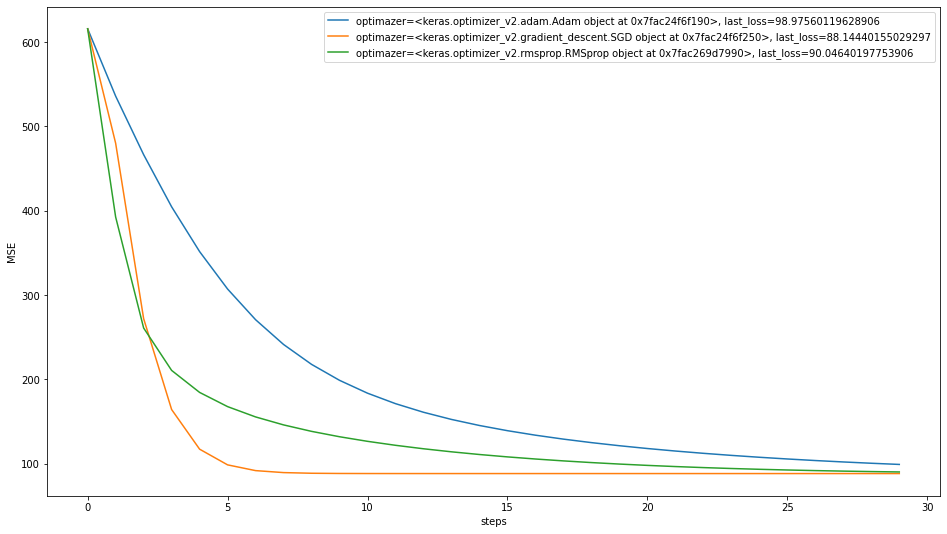

In [ ]:
plt.figure(figsize=(16, 9))


for optimazer in [Adam(learning_rate=1e-3), 
                  SGD(learning_rate=1e-3, momentum=.1),
                  RMSprop(learning_rate=1e-3, momentum=.1)]:
  loss = simple_nn(X_train, 
            y_train, 
            optimazers=optimazer,
            neuron_numbers=500,
            layers_numbers=3,
            epochs=10,
            activations='sigmoid')
  plt.plot(loss,
           label='optimazer={}, last_loss={}'.format(optimazer, round(loss[-1], 4))
  )

  result_table = result_table.append(pd.DataFrame(
    columns=['neuron_num', 'layers_num', 'activation', 'optimizer','loss'],
    data=[[500, 3, 'sigmoid', optimazer, loss[-1]]]))

plt.legend(loc='best')
plt.xlabel('steps')
plt.ylabel('MSE')
plt.show()

In [ ]:
result_table

,neuron_num,layers_num,activation,optimizer,loss
0,2,2,renu,Adam,615.801880
0,10,2,renu,Adam,91.193497
0,500,2,renu,Adam,89.740074
0,10000,2,renu,Adam,88.223701
0,500,2,renu,Adam,92.459419
0,500,3,renu,Adam,88.727356
0,500,6,renu,Adam,615.801880
0,500,8,renu,Adam,88.210854
0,500,3,sigmoid,Adam,88.144463
0,500,3,relu,Adam,88.727356


## Задание №2. Постройте 10-15 вариантов разных нейронных сетей и сведите результаты их работы в таблицу. Опишите, какого результата вы добились от нейросети? Что помогло вам улучшить ее точность?

In [ ]:
result_table

,neuron_num,layers_num,activation,optimizer,loss
0,2,2,renu,Adam,615.801880
0,10,2,renu,Adam,91.193497
0,500,2,renu,Adam,89.740074
0,10000,2,renu,Adam,88.223701
0,500,2,renu,Adam,92.459419
0,500,3,renu,Adam,88.727356
0,500,6,renu,Adam,615.801880
0,500,8,renu,Adam,88.210854
0,500,3,sigmoid,Adam,88.144463
0,500,3,relu,Adam,88.727356


Для улучшения нейронной сети помогло изменение функции активации, увеличени количества слоев > 3 значимого результата не дало. Увеличение количества нейронов > 500 значительного изменения ошибки не дало. Из функций активации наиболее успешным оказался sigmoid. Из оптимизаторов наискорейшее решение находит SGD